In [1]:
## 若在 Colab 上執行請反註解

#### 掛接 Google 雲端硬碟 ####
#from google.colab import drive
#drive.mount('/content/drive')

####　切換工作資料夾的目錄 ####
## root 需要更改成 自己的 資料夾路徑，並資料夾內放 所有 *.py 與 *.ipynb 的檔案。
#root = "/content/drive/MyDrive/Colab Notebooks/GCN-Spanning-Tree"
#import os
#os.chdir(root)

In [2]:
import numpy as np
import networkx as nx
import tensorflow as tf
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time

# 需要有 dataset.py & graph_adj.py & layer.py & gclayer.py檔在目錄下
from dataset import load_Dataset
from graph_adj import get_dict_fn_line_adj, get_dict_fn_p4_adj
from layer import Convert2Dto1D, GraphPool
from gclayer import ChebyshevGraphConvs

# 所有參數 (被移至前面,後面出現已註解掉)

In [3]:
## 【選擇資料集】 ##
# ['mnist', 'fashion_mnist', 'cifar10', 'cifar100']
dataset_name = 'mnist'

## 【選擇 鄰接矩陣adj】 ##
# 四連通、八連通: ['4C', '8C']
# 直線型: ['0', '90', '45', '135', '22.5', '67.5', '112.5', '157.5']
# 遞迴型: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
image_adj = '4C'  

num_K = 9

## 【選擇 訓練參數】 ##
learning_rate = 0.001 # for Adam
batch_size = 128
epochs = 50

# 載入資料集

In [4]:
# from dataset import load_Dataset

# dataset_name = 'mnist'  ## 【選擇資料集】 ##

assert dataset_name in ['mnist', 'fashion_mnist', 'cifar10',
                        'cifar100'], f"{dataset_name} 資料集 不存在"

dataset = load_Dataset(
    dataset_name,
    x_normalization=True,  # 輸入 正規化 0~1
    y_one_hot=True,  # label 使用 one hot encoding
    verbose=True)  # 列印 資料相關資訊

# dataset 為一個字典型態，使用以下 key 來讀取其內容資料
print(f"\n dataset.keys() = { list(dataset.keys()) }")

input_shape = dataset['input_shape']
num_class = dataset['num_class']
x_train = dataset['x_train']
y_train = dataset['y_train']
x_test = dataset['x_test']
y_test = dataset['y_test']

dataset=mnist, num_class=10
[Train] images: shape=(60000, 28, 28, 1), dtype=float32; labels: shape=(60000, 10), dtype=float32
[Test] images: shape=(60000, 28, 28, 1), dtype=float32; labels: shape=(60000, 10), dtype=float32

 dataset.keys() = ['name', 'x_train', 'y_train', 'x_test', 'y_test', 'num_class', 'class_labels', 'input_shape']


# 鄰接矩陣adj 代號說明

In [5]:
# from graph_adj import get_dict_fn_line_adj, get_dict_fn_p4_adj

#說明: get_dict_fn_line_adj() 為 產生【直線型+四連通+八連通】的 鄰接矩陣adj
print(f"line_adj: { list(get_dict_fn_line_adj().keys()) }\n")

#說明: get_dict_fn_p4_adj() 為 產生【遞迴型】的 鄰接矩陣adj
print(f"p4_adj: { list(get_dict_fn_p4_adj().keys()) }\n")


# 單純 為 合併 以上兩個的函數
def get_dict_fn_adj():
    dict_fn_adj = {}
    dict_fn_adj.update(get_dict_fn_line_adj())
    dict_fn_adj.update(get_dict_fn_p4_adj())
    return dict_fn_adj


# 所有可以使用的 鄰接矩陣
print(f"image_adjs: { list(get_dict_fn_adj().keys()) }")

# 四連通、八連通: ['4C', '8C']
# 直線型: ['0', '90', '45', '135', '22.5', '67.5', '112.5', '157.5']
# 遞迴型: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']

line_adj: ['0', '90', '45', '135', '22.5', '67.5', '112.5', '157.5', '4C', '8C']

p4_adj: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']

image_adjs: ['0', '90', '45', '135', '22.5', '67.5', '112.5', '157.5', '4C', '8C', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']


# 計算 正規化後 的 圖拉普拉斯 DAD

In [6]:
#說明: 計算 正規化後 的 圖拉普拉斯
# A = I + adj
# DAD = D^(-1/2) @ A @ D^(-1/2)
def get_sp_DAD(adj, is_smoothing=True):
    N = adj.shape[-1]
    if is_smoothing:  # 圖拉普拉斯 平滑化
        A = sp.eye(N) + sp.coo_matrix(adj)
        # A 的所有元素 皆 >= 0
    else:  # 圖拉普拉斯 銳利化
        A = 2 * sp.eye(N) - sp.coo_matrix(adj)
        # A 的所有元素 還會有 負數
    D = np.power(np.sum(np.abs(A), -1), -0.5)
    DAD = A.multiply(D).T.multiply(D)
    return DAD


def get_sp_L(adj):
    N = adj.shape[-1]
    A = sp.coo_matrix(adj)
    D = np.power(np.sum(np.abs(A), -1), -0.5)
    DAD = A.multiply(D).T.multiply(D)
    return -DAD


#==========#==========#==========#==========#==========#==========#==========#

# image_adj = '4C'  ## 【選擇 鄰接矩陣adj】 ##

num_H, num_W, num_C = input_shape
print(f"input_shape = (H, W, C) = {input_shape}\n")

h1, w1 = num_H, num_W
L1 = get_sp_L(get_dict_fn_adj()[image_adj](h1, w1)).toarray().astype(np.float32)
print(f"L1: h2={h1}, w2={w1}, shape={L1.shape}")

# 產生 第二層 圖卷積 需要的 DADs2
h2, w2 = num_H // 2, num_W // 2
L2 = get_sp_L(get_dict_fn_adj()[image_adj](h2, w2)).toarray().astype(np.float32)
print(f"L2: h2={h2}, w2={w2}, shape={L2.shape}")

input_shape = (H, W, C) = (28, 28, 1)

L1: h2=28, w2=28, shape=(784, 784)
L2: h2=14, w2=14, shape=(196, 196)


# 建立Chebyshev  GCN模型

In [7]:
# from layer import Convert2Dto1D, GraphPool
# from gclayer import GraphConvs

# num_K = 9
dropout_rate = 0.5
#==========#==========#==========#==========#==========#==========#==========#
Input = tf.keras.layers.Input(shape=input_shape, name='Input')

x = Convert2Dto1D(name='Reshape')(Input)  # Reshape (H, W, C) --> (H*W, C)

x = ChebyshevGraphConvs(units=32, L=L1, K=num_K, name='ChebyGConv32')(x)
x = tf.keras.layers.ReLU(name='relu_1')(x)
x = GraphPool(num_H=h1, num_W=h1, name='Gpool_1')(x)

x = ChebyshevGraphConvs(units=64, L=L2, K=num_K, name='ChebyGConv64')(x)
x = tf.keras.layers.ReLU(name='relu_2')(x)
x = GraphPool(num_H=h2, num_W=w2, name='Gpool_2')(x)

x = tf.keras.layers.Flatten(name='Flatten')(x)

x = tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout')(x)
x = tf.keras.layers.Dense(units=num_class, name='F10')(x)
x = tf.keras.layers.Softmax(name='softmax')(x)

model = tf.keras.Model(inputs=Input, outputs=x)
#==========#==========#==========#==========#==========#==========#==========#

model.summary(line_length=120)

Model: "functional_1"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
Input (InputLayer)                                    [(None, 28, 28, 1)]                             0                 
________________________________________________________________________________________________________________________
Reshape (Convert2Dto1D)                               (None, 784, 1)                                  0                 
________________________________________________________________________________________________________________________
ChebyGConv32 (ChebyshevGraphConvs)                    (None, 784, 32)                                 320               
________________________________________________________________________________________________________________________
relu_1 (Re

# 訓練模型

In [8]:
# learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
#==========#==========#==========#==========#==========#==========#==========#
# batch_size = 128
# epochs = 50
validation_split = 0.1

st = time.time()
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    verbose=2)
train_time = time.time() - st

loss = history.history['loss'][-1]
acc = history.history['accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"train_time = {train_time:6.2f} sec")
print(f"Train: loss = {loss:8.6f}, acc = {acc*100:6.3f}%")
print(f"Val  : loss = {val_loss:8.6f}, acc = {val_acc*100:6.3f}%")

Epoch 1/50
422/422 - 19s - loss: 0.4368 - accuracy: 0.8692 - val_loss: 0.1295 - val_accuracy: 0.9620
Epoch 2/50
422/422 - 18s - loss: 0.1484 - accuracy: 0.9549 - val_loss: 0.0815 - val_accuracy: 0.9740
Epoch 3/50
422/422 - 19s - loss: 0.1081 - accuracy: 0.9669 - val_loss: 0.0643 - val_accuracy: 0.9800
Epoch 4/50
422/422 - 19s - loss: 0.0890 - accuracy: 0.9727 - val_loss: 0.0578 - val_accuracy: 0.9800
Epoch 5/50
422/422 - 19s - loss: 0.0774 - accuracy: 0.9766 - val_loss: 0.0533 - val_accuracy: 0.9833
Epoch 6/50
422/422 - 18s - loss: 0.0691 - accuracy: 0.9788 - val_loss: 0.0517 - val_accuracy: 0.9840
Epoch 7/50
422/422 - 18s - loss: 0.0622 - accuracy: 0.9808 - val_loss: 0.0507 - val_accuracy: 0.9853
Epoch 8/50
422/422 - 18s - loss: 0.0567 - accuracy: 0.9823 - val_loss: 0.0466 - val_accuracy: 0.9865
Epoch 9/50
422/422 - 18s - loss: 0.0535 - accuracy: 0.9828 - val_loss: 0.0407 - val_accuracy: 0.9885
Epoch 10/50
422/422 - 18s - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0409 - val_accura

# 驗證 模型

In [9]:
st = time.time()
test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=1)
test_time = time.time() - st

print(f"test_time = {test_time:6.2f} sec")
print(f"Test : loss = {test_loss:8.6f}, acc = {test_acc*100:6.3f}%")

313/313 [==============================] - 10s 30ms/step - loss: 0.0277 - accuracy: 0.9921
test_time =   9.63 sec
Test : loss = 0.027657, acc = 99.210%


# 畫 準確率曲線

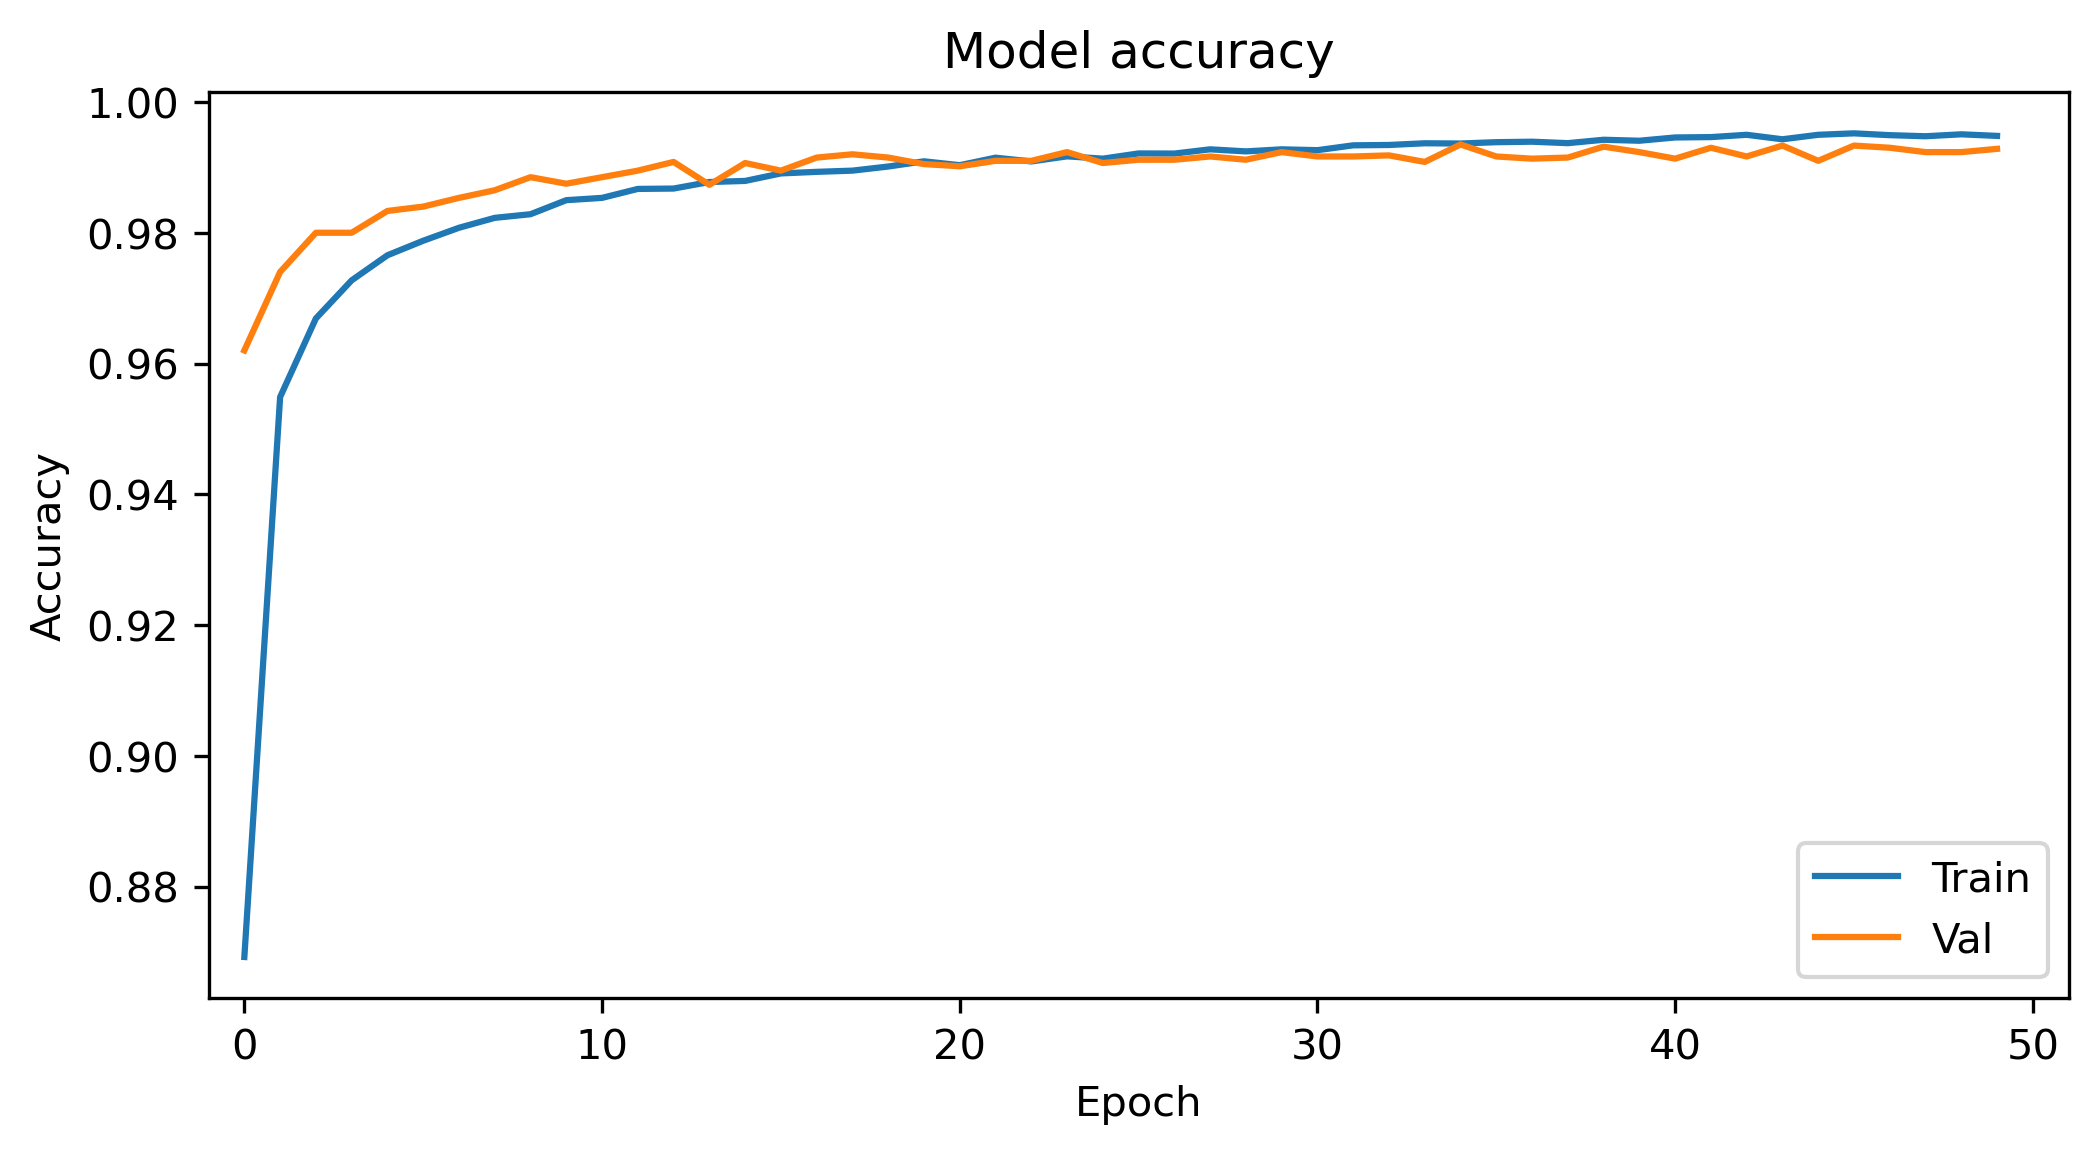

In [11]:
def plt_history_accuracy(history=None, acc=None, val_acc=None):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    if history is not None:
        ax.set_xlim(left=-1, right=history.epoch[-1] + 2)
        ax.plot(history.history['accuracy'])
        ax.plot(history.history['val_accuracy'])
    if acc is not None and val_acc is not None:
        ax.set_xlim(left=-1, right=len(acc) + 1)
        ax.plot(acc)
        ax.plot(val_acc)
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='best')
    plt.close()
    return fig

fig = plt_history_accuracy(history)
# 儲存圖片
fig.savefig(f"Chebyshev_GCN_{dataset_name}_{image_adj}_acc.png",
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.0)

# 顯示圖片
fig

# 畫 Loss曲線

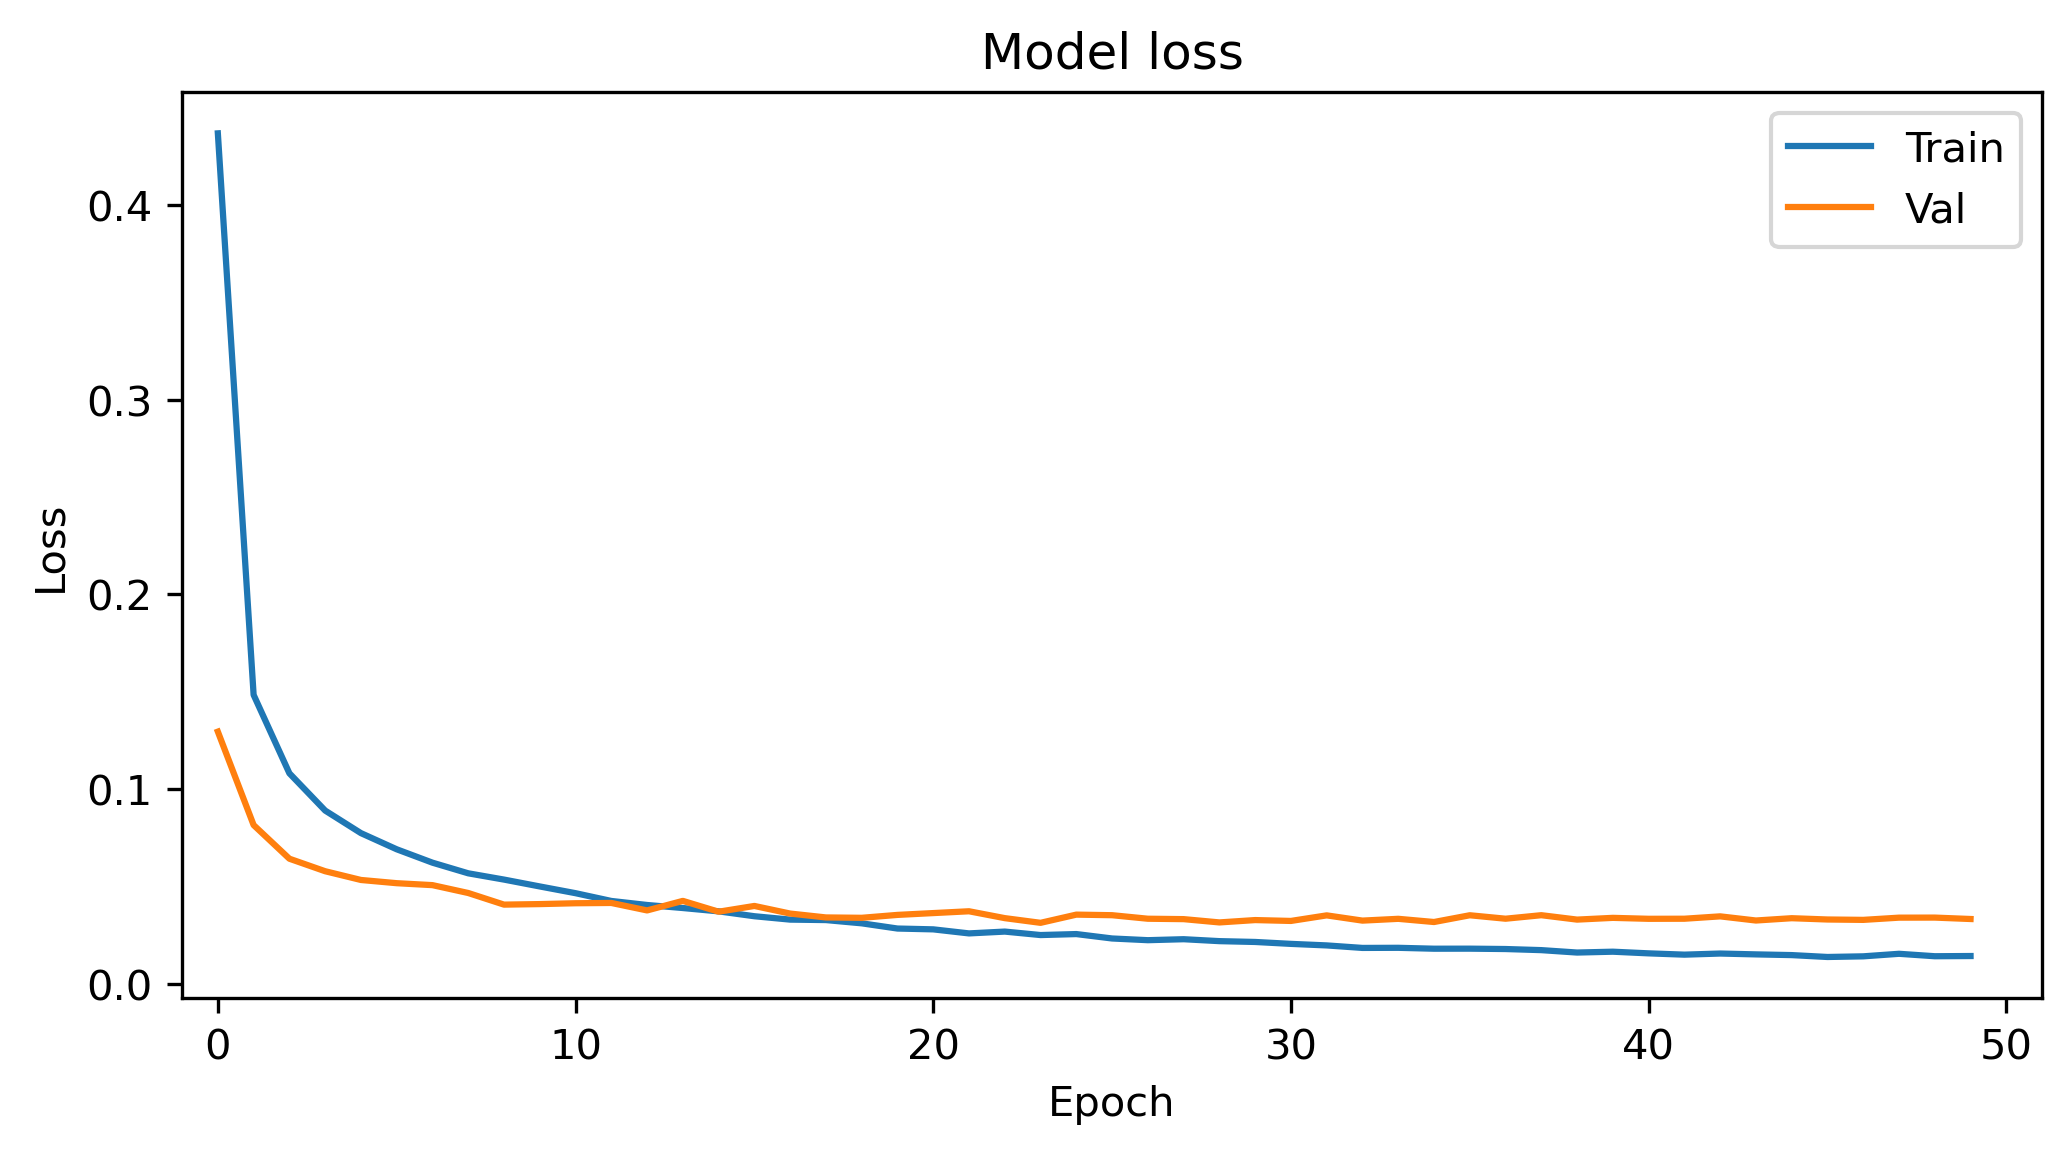

In [12]:
def plt_history_loss(history=None, loss=None, val_loss=None):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    if history is not None:
        ax.set_xlim(left=-1, right=history.epoch[-1] + 2)
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
    if loss is not None and val_loss is not None:
        ax.set_xlim(left=-1, right=len(loss) + 1)
        ax.plot(loss)
        ax.plot(val_loss)
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='best')
    plt.close()
    return fig

fig = plt_history_loss(history)
# 儲存圖片
fig.savefig(f"Chebyshev_GCN_{dataset_name}_{image_adj}_loss.png",
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.0)
# 顯示圖片
fig